In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

CLASSES_MARKERS = { 0: 's', 1: '^', 2: 'o',3: 'v' }


In [91]:
def get_feature_matrix(masstime, data, significant=True):
    if not significant:
        return data.iloc[3:,8:].to_numpy(dtype=float).T
    inds=[]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.asarray(inds, dtype=int)
    return data.iloc[inds,8:].to_numpy(dtype=float).T

def get_ids(data):
    ID=[]
    for line in data.iloc[2,8:]:
        ID.append(line.split('_')[-1].split('.')[0])
    return np.array(ID)

def add_noise(x, magnitude):
    return x + np.random.normal(0,magnitude, x.shape)

In [9]:
path_s = "../../PDproj/cellresults/ttest/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
filenames_s

['cellshilicneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicsneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicspos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv']

In [10]:
path = "../../PDproj/celldata/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicneg_log2.csv',
 'cellshilicpos_log2.csv',
 'cellslipidomicsneg_log2.csv',
 'cellslipidomicspos_log2.csv',
 'cellsRPneg_log2.csv',
 'cellsRPpos_log2.csv',
 'mediumHILICneg_log2.csv',
 'mediumHILICpos_log2.csv',
 'mediumRPneg_log2.csv',
 'mediumRPpos_log2.csv']

In [360]:
fnum=9 # 2 is good example
data = pd.read_csv(path + filenames[fnum], sep=';', header=None)
tle = filenames[fnum].split('_')[0]
data_s = pd.read_csv(path_s + filenames_s[fnum],sep=';')
filenames[fnum]

'mediumRPpos_log2.csv'

### Get significant features by matching masstimes

In [361]:
masstime = data_s[' masstime'].to_numpy()
groups=data.iloc[0,8:]
labels = LabelEncoder().fit_transform(groups)
ID=get_ids(data)
x=get_feature_matrix(masstime, data, True)
assert(x.shape[0]==40)

In [420]:
pca = PCA().fit_transform(x)
pca = add_noise(pca, 1)

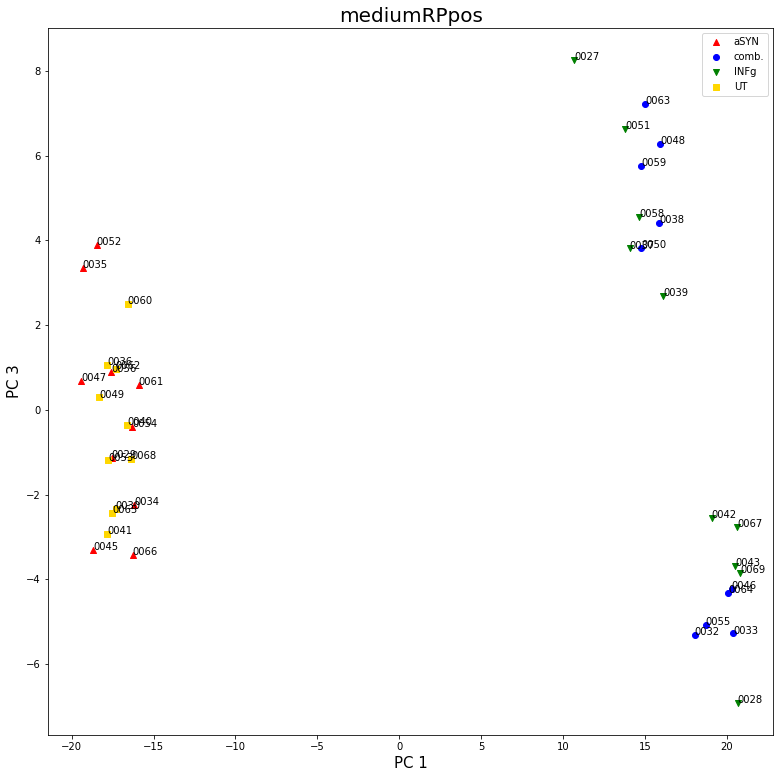

In [421]:
SAVE=False
k=2
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red')
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue')
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green')
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold')
ax.legend(['aSYN','comb.','INFg','UT'])

for i, txt in enumerate(ID):
    ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=10)
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC {}'.format(k+1), fontsize=15)
plt.title(tle, fontsize=20)
plt.show()

if SAVE:
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle))